## Data analysis code for gain=1000 and gain=5000 data taken on 02/25/2025 and 02/27/2025. Plots histogram and fits with a Gaussian.

In [125]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py

## Define functions for Gaussian fitting

In [126]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [127]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

# Define PC thresholds for binning=1x1
Code copied from 03/13/2025

In [128]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\14'

Text(0, 0.5, 'Number of Pixels')

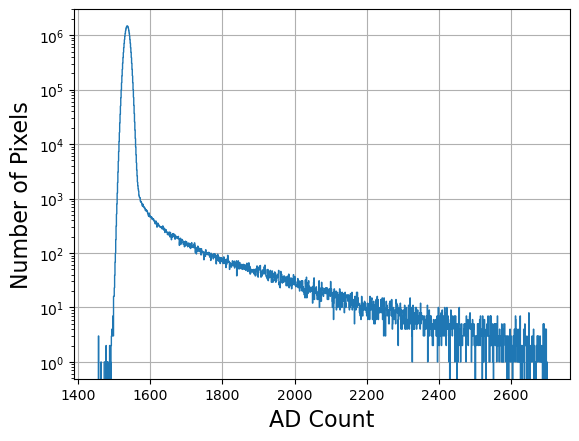

In [129]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0033'
for count_b, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    with h5py.File(file_path, 'r') as file:
        image_data = file['images/camera/fluorescence/frame'][:]
        all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 300 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[3.30075725e-01 7.00000000e+00 1.53600000e+03]
[69, 104, 1513, 1560, 1480, 1900]
fit region: AD count =  1520 to  1554
Fit Converged
Converged with chi-squared 1143.97733192801
Number of degrees of freedom, dof = 32
Reduced chi-squared 35.74929162275031
Inital guess values:
  p0 = [0.3300757251995773, 7, 1536]
Best fit values:
  pf = [0.33159626061420455, 7.053756389805885, 1536.511763702204]
Uncertainties in the best fit values:
  pferr = [6.558508474560814e-05, 0.0012120258477918739, 0.001460700535238994]
5 sigma threshold is 1571.7805456512335 with uncertainty 0.007520829774198363


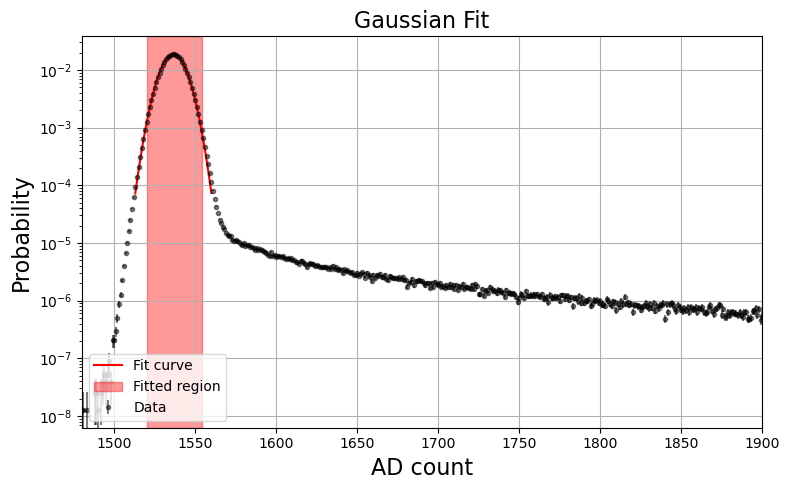

In [130]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1520
End_gaussian=1555

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +5

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Binning 1x1

In [131]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\03\14'
seq_binning1 = [24, 26, 25, 29] #binning=1x1
labels = ['YAG=865V,','YAG=850V,', 'YAG=840V,', 'Background,']

1538
1535
1535
1535


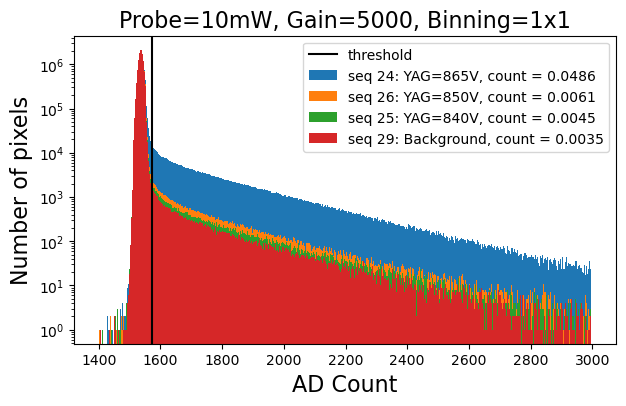

In [132]:
counting_threshold = 1572
number_of_pics=50
all_images_binning1 = np.full((len(seq_binning1), number_of_pics-1, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==0: #skip the bucketing noise figure
            continue
        if count_b==number_of_pics:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, (count_b-1), :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 3)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1.0, label = 'seq %i: '%seq_binning1[i]+ labels[i] +' count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=10mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

### Spatial distribution

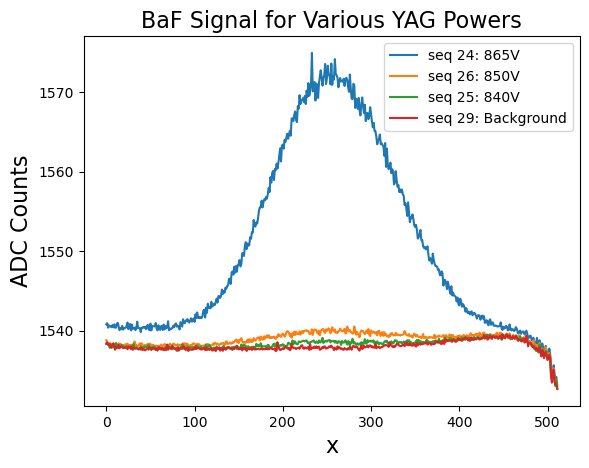

In [122]:
for i, images in enumerate(all_images_binning1):
    cross_section_x = np.mean(all_images_binning1[i,:,:,:], axis=(0,1))
    plt.plot(cross_section_x,  label = 'seq %i: '%seq_binning1[i]+ labels[i])

plt.xlabel('x', fontsize=16)
plt.title('BaF Signal for Various YAG Powers', fontsize=16)
plt.ylabel('ADC Counts', fontsize=16)
plt.legend()


## Let's compare SNR for varied probe powers...

In [133]:
seq_binning1 = [20, 31] #binning=1x1
labels = ['20mW Molecule', '20mW Molecule']
counting_threshold = 1572
number_of_pics=100

1538
1535


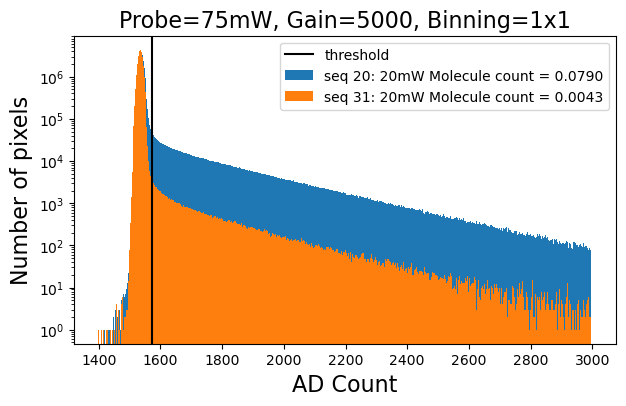

In [134]:
all_images_binning1 = np.full((len(seq_binning1), number_of_pics-1, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==0: #skip the bucketing noise figure
            continue
        if count_b==number_of_pics:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images_binning1[count_a, (count_b-1), :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 3)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1.0, label = 'seq %i: '%seq_binning1[i]+ labels[i] +' count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=75mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

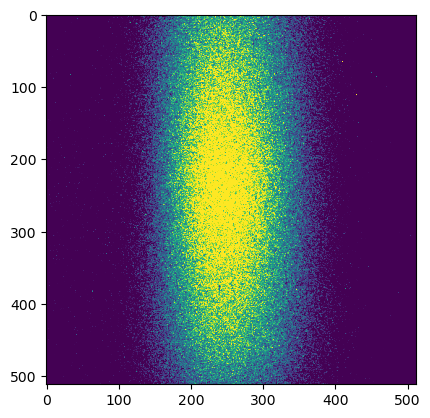

In [137]:
plt.imshow(np.mean(all_images_binning1[0,:,:,:], axis = 0), vmin = 1550, vmax = 1600)

1538
1538
1535


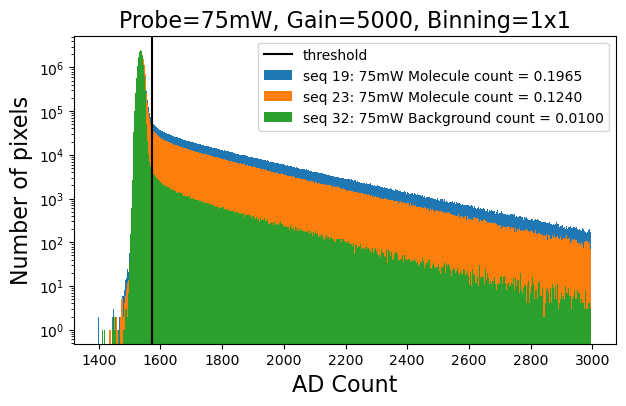

In [117]:
all_images_binning1 = np.full((len(seq_binning1), number_of_pics-1, 512, 300), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==0: #skip the bucketing noise figure
            continue
        if count_b==number_of_pics:
            break
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:, 80:380]
            all_images_binning1[count_a, (count_b-1), :, :] = image_data

counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 3)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1.0, label = 'seq %i: '%seq_binning1[i]+ labels[i] +' count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=75mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()